In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
from urllib.parse import urlencode
import scipy.stats
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import chi2_contingency, chi2

# Задание 1.
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

Формат данных, подаваемых в функцию:  
1) df_1 - ДФ с данными об авторизации.  
2) df_2 - ДФ с данными о регистрациях.  
3) count_from - дата, от которой считается Retention в формате 'yyyy-mm-dd'.  
4) count_for - кол-во дней, для которых будет вестись подсчет.

In [2]:
%%time 
# Загрузим наши данные.
df_1 = pd.read_csv('problem1-auth_data.csv', sep = ';')
df_2 = pd.read_csv('problem1-reg_data.csv', sep = ';')

CPU times: user 1.78 s, sys: 584 ms, total: 2.37 s
Wall time: 2.36 s


In [3]:
def retention_count(df_1, df_2, count_from, count_for):
    count_from = pd.to_datetime(count_from) # Дату, от которой рассчитываем ретеншн, сразу в таймстемп.
    count_to = count_from + pd.Timedelta(days = count_for) # Конечная дата (старт + продолжительность).
    df = df_1.merge(df_2, how = 'left', on = 'uid') # Мёрджим 2 ДФ'а.
    # df['diff'] = round(((df.auth_ts - df.reg_ts) / 86400), 0) # Разницу считаем сразу, пока данные в секундах,
    # иначе в конце на визуализации шкала дней неверно отображается. Но этот способ не подходит, неправильно округляет
    df['auth_ts'] = pd.to_datetime(df.auth_ts, unit = 's').dt.date # Секунды в дату.
    df['reg_ts'] = pd.to_datetime(df.reg_ts, unit = 's').dt.date # Секунды в дату.
    df['diff'] = (df.auth_ts - df.reg_ts ).dt.days   # Вот так правильно, только дни берет.
    df = df.query('reg_ts >= @count_from and auth_ts <= @count_to') # Фильтр.
    df = df.pivot_table(index = 'reg_ts', columns = 'diff', values = 'uid', aggfunc = 'nunique') # Делаем сводную таблицу.
    cohort_sizes = df.iloc[:, 0] # День регистрации с количеством регистраций.
    retention = df.divide(cohort_sizes, axis=0) # Делим ДФ на 1ый столбец = Ретеншн.
    plt.figure(figsize = (40, 25))
    plt.title('Retention', fontsize = 25) #
    sns.heatmap(retention, vmin = 0.0, vmax = 0.1,
                cmap = 'Oranges', linewidths=3, linecolor='black',
                fmt = '.1%', annot = True, cbar=False)
    plt.ylabel('Registration Date', fontsize = 25) 
    plt.xlabel('Cohort period', fontsize = 15)
    plt.show()

Выполним тестовый запуск

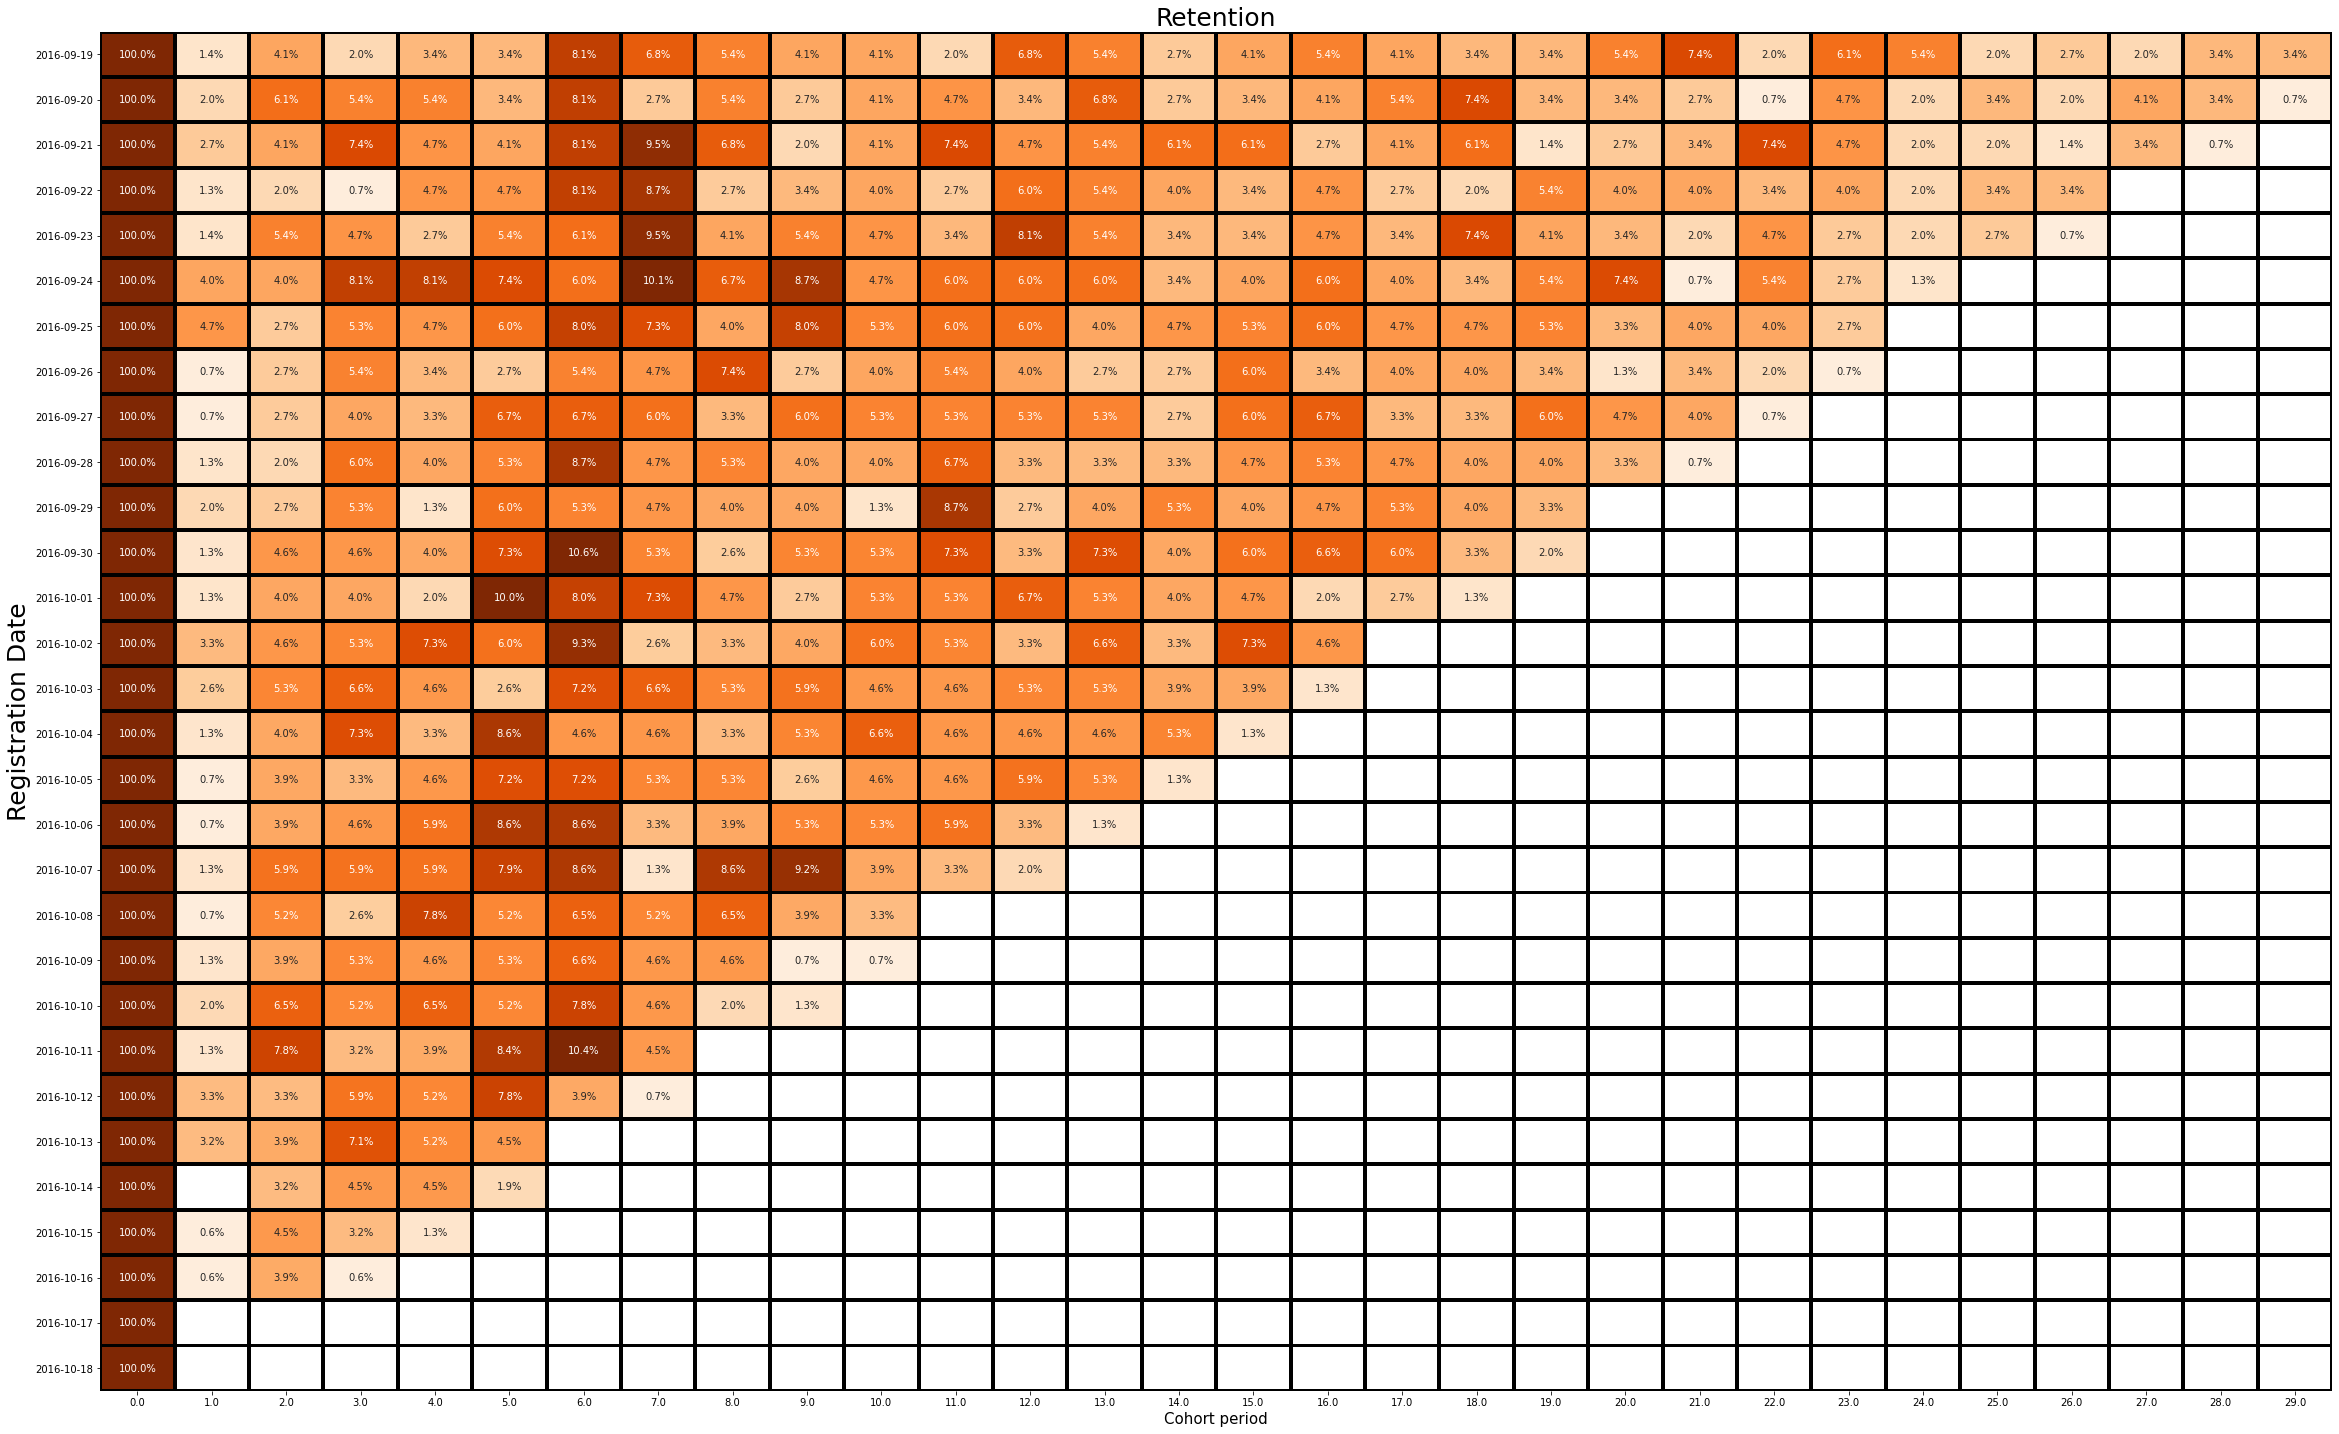

CPU times: user 14.2 s, sys: 16.3 s, total: 30.5 s
Wall time: 29.7 s


In [4]:
%%time
retention_count(df_1, df_2, '2016-09-19', 29)

# Задание 2.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

Подключимся к Яндекс.Диску и загрузим наши данные.

In [5]:
api = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
link = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'
link_prom = requests.get(api + urlencode({'public_key': link}))
link_end = json.loads(link_prom.text)['href']

In [6]:
df = pd.read_csv(link_end, sep=';')  
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [7]:
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Зададим факт покупки - 1, отсутствие покупки - 0. Для А/A теста. Не уверен, что он тут нужен, но проверить стоит.

In [8]:
df['paid'] = np.where(df.revenue > 0, 1, 0)
df.head()

,user_id,revenue,testgroup,paid
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [9]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

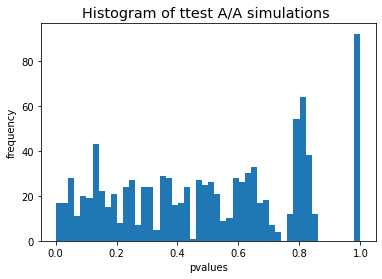

0.046

In [10]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_a.paid.sample(n_s, replace = False).values
    s2 = df_b.paid.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Вероятность ошибиться - менее 5%. Разделены группы правильно.

Небольшое дополнение самиму себе на будущее. В А/А тесте делается т-тест для колонки paid, т.е. для биноминального признака, все-таки у т-теста нулевая гипотеза о равенстве средних. Поэтому здесь данный тест может быть не очень корректен.

По-другому промаркируем тех, кто заплатил. Так будет удобнее.

In [11]:
df['paid'] = np.where(df.revenue > 0, 'converted', 'not_converted')
df.head()

,user_id,revenue,testgroup,paid
0,1,0,b,not_converted
1,2,0,a,not_converted
2,3,0,a,not_converted
3,4,0,b,not_converted
4,5,0,b,not_converted


Снова поделим на группы после 2ой маркировки.

In [12]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

Нам известно, что ARPU в тестовой на 5% выше, чем в контрольной. Значит логично будет посчитать еще ARPPU и конверсию. 
Такженеобходимо определить какая группа тестовая, а какая контрольная.

In [13]:
df_conv = df.groupby(['testgroup', 'paid'], as_index=False) \
    .agg({'user_id': 'count'})\
    .pivot(index='testgroup', columns='paid', values='user_id')
df_conv['conversion'] = (df_conv.converted / (df_conv.converted + df_conv.not_converted)).mul(100).round(2)
df_conv

paid,converted,not_converted,conversion
testgroup,,,
a,1928,200175,0.95
b,1805,200862,0.89


Конверсия в группе А выше.

Посчитаем метрики, с которыми определились выше.

ARPU - Revenue / Users.

ARPPU - Revenue / Paying Users.

In [14]:
ARPU_a = df_a.revenue.sum() / df_a.user_id.nunique()  
ARPU_b = df_b.revenue.sum() / df_b.user_id.nunique()  
ARPPU_a = df_a.query('paid == "converted"').revenue.sum() / df_a.query('paid == "converted"').user_id.nunique()  
ARPPU_b = df_b.query('paid == "converted"').revenue.sum() / df_b.query('paid == "converted"').user_id.nunique()

In [15]:
print(ARPU_a.round(2), ARPU_b.round(2))
print(ARPPU_a.round(2), ARPPU_b.round(2))
print((((ARPU_b - ARPU_a) / ARPU_b)*100).round(2))
print((((ARPPU_b - ARPPU_a) / ARPPU_b)*100).round(2))

25.41 26.75
2664.0 3003.66
5.0
11.31


Искомые 5% разницы ARPU.

ARPU в группе 'B' на 5% выше, чем в группе 'A'. Отсюда вывод, что группа 'B' - тестовая, 'A' - контрольная.

In [16]:
df.groupby('testgroup').agg({'revenue' : 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


Предварительный итог: ARPU и ARPPU в тестовой группе увеличились на 5% и 11.31%. Общая выручка увеличилась. Конверсия упала. Cтат. значимость необходимо проверить.

In [17]:
scipy.stats.mannwhitneyu(df_a.revenue,df_b.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Полученный результат по различию в выручке не яляется стат. заничимым, так как p > 0.05. Соотвественно мы не можем отвернунть Н0.

Проверяем платящих пользователей (Paying Users).

In [18]:
df_control = df_a.query('paid == "converted"')
df_test = df_b.query('paid == "converted"')

In [19]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

In [20]:
print(round(np.mean(df_control.revenue), 2))
print(np.median(df_control.revenue))

2664.0
311.0


В контрольной группе наблюдаем выбросы.

In [21]:
print(round(np.mean(df_test.revenue),2 ))
print(np.median(df_test.revenue))

3003.66
3022.0


В тестовой выбросы отсутствуют.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Test group')

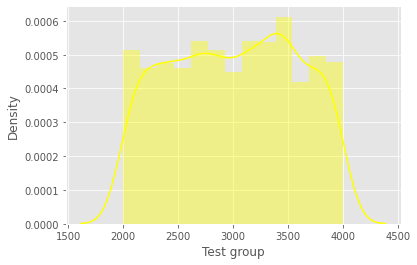

In [22]:
sns.distplot(df_test.revenue, color = 'yellow')
plt.xlabel('Test group')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Control group')

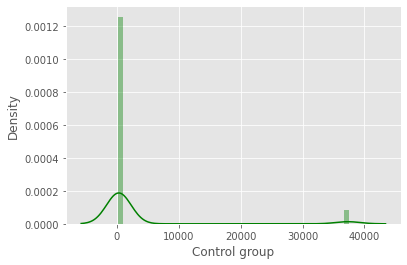

In [23]:
sns.distplot(df_control.revenue, color = 'green')
plt.xlabel('Control group')

Подтверждаем, что в контрольной группе присутствуют выбросы. В тестовой распределение не нормальное. Значения выбросов в районе 30к-40к.

Убедимся, что распределение в тестовой группе ненормальное.

Зачем нам тут семплирование ? Так как тест Шапиро-Уилка достаточно чувствительный к большим выборкам и, таким образом, на больших выборках могут получаться неверные результаты. Другими словами, если выборка достаточно большая, то он будет детектировать даже самые небольшие отклонения от нормального распределения, повышая вероятность ошибки первого рода (ложноположительный результат), т.е. это ситуация, когда отвергнута верная нулевая гипотеза.

In [29]:
df_test_sample = df_test.sample(5000, replace = True)

In [31]:
scipy.stats.shapiro(x = df_test_sample.revenue)

ShapiroResult(statistic=0.9603670835494995, pvalue=6.53540076363022e-35)

H0 можно отбросить. Распределение ненормальное. Подтверждаем.

In [32]:
df_control.query('revenue > 30000') # 123 странные транзакции. Тут попробовал разные значения. Результат одинаковый = 123

,user_id,revenue,testgroup,paid
416,417,37324,a,converted
4428,4429,37304,a,converted
5777,5778,37315,a,converted
8065,8066,37307,a,converted
8743,8744,37334,a,converted
...,...,...,...,...
360696,360697,37347,a,converted
378668,378669,37297,a,converted
389341,389342,37298,a,converted
394580,394581,37302,a,converted


Дальше уже не использую т-тест. На всякий случай отмечу этот момент: ненормальность распределения еще не повод отказываться от т-теста. Выборочные средние, согласно центральной предельной теореме, вполне могут быть распределены нормально. Тут нужно более веское основание для такого отказа (и хорошо бы объяснять, почему в итоге выбирается именно тот или иной метод). Необходимость нормального распределения критична для маленьких выборок, в частности, меньше тридцати. Другим ограничением для выполнения т-теста может быть однородность (гомогенность) дисперсий в выборках. Нужно это проверить.

In [33]:
stats.mannwhitneyu(df_control.revenue, df_test.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Различия стат значимые для данных с выбросами. Проделаем то же самое, исключив выбросы.

In [34]:
df_control_test = df_control.query('revenue < 30000')

In [35]:
stats.mannwhitneyu(df_control_test.revenue, df_test.revenue)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

Для платящих пользователей различия в выручке стат. значимы для данных с выбросами и без. 

In [36]:
stats.mannwhitneyu(df_a.revenue, df_b.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

На полных данных стат. значимой разницы для выручки не наблюдается.

Подтвердим все вышесделанное бустрэп'ом. Этот метод не критичен к нормальности распределения.

In [37]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


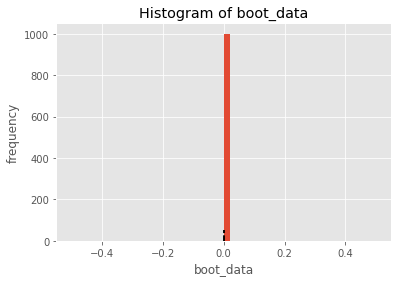

nan

In [38]:
booted_data = get_bootstrap(
    df_a.revenue, 
    df_b.revenue,
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95) # уровень значимости
booted_data["p_value"]

На полных данных стат. значимой разницы нет.

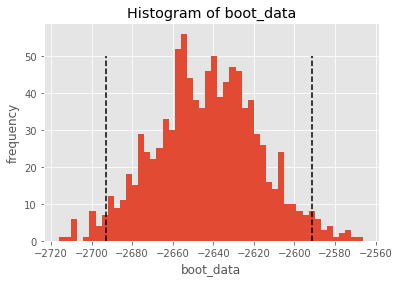

0.0

In [39]:
booted_data = get_bootstrap(
    df_control.revenue, 
    df_test.revenue,
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95) # уровень значимости
booted_data["p_value"]

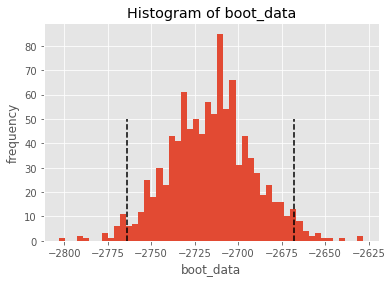

0.0

In [40]:
booted_data_1 = get_bootstrap(
    df_control_test.revenue, 
    df_test.revenue,
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95) # уровень значимости
booted_data_1["p_value"]

Для платящих пользователей подтвреждается стат. значимость разницы в выручке, как с "выбросами", так и без.

In [41]:
df_chi = df_conv.drop(['conversion'], axis = 1)
df_chi

paid,converted,not_converted
testgroup,,
a,1928,200175
b,1805,200862


Проверим есть ли стат. значимые различия в конверсии.

In [42]:
chi2_contingency(df_chi)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[  1863.89924896, 200239.10075104],
        [  1869.10075104, 200797.89924896]]))

Есть стат. значимая разница в конверсии.

# Выводы:
В тестовую и контрольную группы попали разные пользователи. В контрольной большинство - 93.62% составляют пользователи, потратившие относительно небольшую сумму (около 200р) и некоторое количество пользователей – 6.38%, потративших большую сумму (возможно VIP пользователи ?). В тестовой же платили в интервале от 2000 до 4000.
Отсюда 2 предположения:  
    1: Предложение контрольной группы привлекло маленькую, но платежеспособную аудиторию, но большинству платящих пользователей предложение либо не понравилось, либо они брали самый дешевый пак из предложения.  
    2: Эти 6.38% - ошибка сбора данных, необходимо это проанализировать отдельно.  

Предположим, что эти 123 пользователя абсолютно реальны. Тогда, ориентируясь на ARPU, ARPPU, общую повышенную revenue  и даже несмотря на стат. значимо упавшую конверсию, я бы предлагал набор Б (тестовый). По моему мнению лучше стабильно получать денежный поток с понятным и предсказуемым средним чеком, чем надеяться привлечь маленькую, но очень платежеспособную аудиторию.

# Задание 3.  
## Часть 1.  
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?
Retention rate – заходили ли игроки повторно с момента запуска события.  
<ins>DAU, WAU</ins> – dau нам покажет реакцию людей в моменте, а wau покажет есть ли стабильный интерес (ивент же дольше недели идет ?).  
<ins>Conversion</ins> – в покупку. % задонативших.  
<ins>ARPU, ARPPU</ins> – сколько зарабатываем в среднем на пользователе, сколько в среднем на платящем пользователе (клиенте).  
<ins>Number of Sessions</ins> – количество сессий в событии.  
<ins>Sessions per User</ins> - количество сессий в событии на 1 пользователя.  
<ins>Average Session Length (ASL)</ins> – средняя продолжительность сессии.  
<ins>Average number of levels (ALL)</ins> – среднее количество пройденных за сессию уровней. Нужно смотреть вместе с ASL и ALL. Круто, если и продолжительность сессии большая и уровней адекватное количество, важно, чтобы оттока не последовало. Вдруг игроки где-то застрянут, уровень может юыть сложноват.  
<ins>Average level Length</ins> – среднее время прохождения уровня (можно отслеживать каждый уровень).  
<ins>Абсолютная конверсия для 4х уровней: 1ая награда, 50% наград, 90% наград, 100% наград</ins> – нужно понимать за чем «охотились» игроки, начавшие участвовать в событии, были ли для них ценными предложенные награды.

## Часть 2.
Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?  
Набор метрик координально не поменяется, но расширится. Вообще откат на уровни ниже звучит как что-то очень отталкивающее. Такого себе даже Хидетака не позволяет.  
<ins>Относительная конверсия из уровня в уровень</ins> – нужно понимать с какого уровня идет наибольший отток, может надо будет какой-нибудь упростить.  
<ins>Среднее количество попыток на игровую сессию.</ins>  
<ins>WR</ins> – средне количество пройденных уровней перед 1ым откатом.  
<ins>Доля игроков, откатившихся в самое начало. </ins> 